## 3.1.4 Challenge: Model Comparison

You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.formula.api import ols

I'm using a dataset of open, high, low and close bid prices for the FTSE100 market, corresponding to the 15 minute time frame, from October 2017 through April 2018.

In [2]:
data_path = '/home/mache/Desktop/Thinkful/Course/Unit 3/GBRIDXGBP_15 Mins_Bid_2017.10.01_2018.04.01.csv'
df = pd.read_csv(data_path)[['Time (ART)','Open', 'High', 'Low', 'Close']]
display(df.shape)
display(df.head(3))

(12480, 5)

,Time (ART),Open,High,Low,Close
0,2017.10.01 18:00:00,7374.969,7374.969,7374.969,7374.969
1,2017.10.01 18:15:00,7374.969,7374.969,7374.969,7374.969
2,2017.10.01 18:30:00,7374.969,7374.969,7374.969,7374.969


In [3]:
df.describe()

,Open,High,Low,Close
count,12480.000000,12480.000000,12480.000000,12480.000000
mean,7417.746102,7420.042335,7415.386699,7417.709764
std,209.611137,208.999603,210.277273,209.629732
min,6858.100000,6865.600000,6851.609000,6858.349000
25%,7249.550000,7251.400000,7244.764000,7249.512250
50%,7458.770000,7459.800000,7456.770000,7458.770000
75%,7549.269000,7552.270000,7548.269250,7549.269000
max,7788.969000,7792.770000,7786.269000,7788.770000


### Adding the Commodity Channel Index (CCI) to our dataset

CCI is a versatile momentum oscillator that can be used to identify overbought/oversold levels or trend reversals. The indicator becomes overbought or oversold when it reaches a relative extreme.

In [4]:
# Commodity Channel Index 
def CCI(df, ndays): 
 TP = (df['High'] + df['Low'] + df['Close']) / 3 
 CCI = pd.Series((TP - pd.rolling_mean(TP, ndays)) / (0.015 * pd.rolling_std(TP, ndays)),
 name = 'CCI') 
 df = df.join(CCI) 
 return df

In [5]:
# Compute the Commodity Channel Index(CCI) for FTSE100 based on the 20-day Moving average
n = 20
FTSE_CCI = CCI(df, n)
CCI = FTSE_CCI['CCI']

/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  after removing the cwd from sys.path.
/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  after removing the cwd from sys.path.


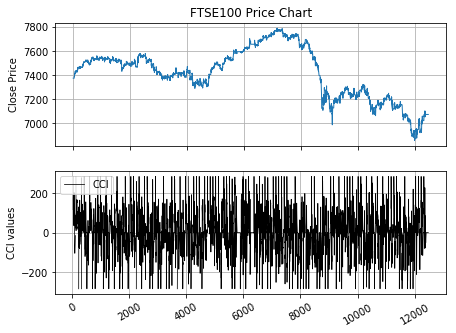

In [6]:
# Plotting the Price Series chart and the Commodity Channel index below
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticklabels([])
plt.plot(df['Close'],lw=1)
plt.title('FTSE100 Price Chart')
plt.ylabel('Close Price')
plt.grid(True)
bx = fig.add_subplot(2, 1, 2)
plt.plot(CCI,'k',lw=0.75,linestyle='-',label='CCI')
plt.legend(loc=2,prop={'size':10})
plt.ylabel('CCI values')
plt.grid(True)
plt.setp(plt.gca().get_xticklabels(), rotation=30)
plt.show()

In [7]:
df = pd.concat([df, CCI], axis=1)

In [8]:
df2 = df.replace([np.inf, -np.inf], np.nan)

In [9]:
df2 = df2.replace([np.inf, -np.inf], np.nan).dropna(subset=["CCI"], how="all")

In [10]:
df2.head(5)

,Time (ART),Open,High,Low,Close,CCI
36,2017.10.02 03:00:00,7383.969,7385.47,7380.769,7383.969,283.235277
37,2017.10.02 03:15:00,7384.269,7386.27,7382.269,7384.469,205.978172
38,2017.10.02 03:30:00,7384.269,7386.77,7382.770,7382.770,157.661018
39,2017.10.02 03:45:00,7382.969,7384.47,7379.770,7384.269,114.071201
40,2017.10.02 04:00:00,7383.970,7391.77,7373.969,7390.969,136.717910


In [11]:
df2.describe()

,Open,High,Low,Close,CCI
count,12318.000000,12318.000000,12318.000000,12318.000000,12318.000000
mean,7417.580891,7419.907322,7415.190458,7417.544075,2.019403
std,210.942122,210.328114,211.610718,210.960813,81.860573
min,6858.100000,6865.600000,6851.609000,6858.349000,-283.235277
25%,7245.276500,7250.704750,7241.040000,7245.021500,-42.918377
50%,7458.770000,7461.270000,7458.119000,7458.770000,0.000007
75%,7551.470000,7552.969000,7549.269000,7551.419250,47.231402
max,7788.969000,7792.770000,7786.269000,7788.770000,283.235280


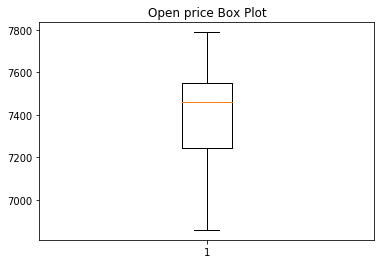

In [12]:
#Plot outcome variable
plt.boxplot(df2['Open'])
plt.title("Open price Box Plot")
plt.show()

## Applying PCA

In [13]:
#Define X and Y
X = df2[['High', 'Low', 'Close','CCI']]
Y = df2['Open']

In [14]:
X_data = X
print(X_data.head())
print('Shape: ', X_data.shape)

       High       Low     Close         CCI
36  7385.47  7380.769  7383.969  283.235277
37  7386.27  7382.269  7384.469  205.978172
38  7386.77  7382.770  7382.770  157.661018
39  7384.47  7379.770  7384.269  114.071201
40  7391.77  7373.969  7390.969  136.717910
Shape:  (12318, 4)


In [15]:
#Target data
Y_target = Y
print(Y_target.head())
print('Shape: ', Y_target.shape)

36    7383.969
37    7384.269
38    7384.269
39    7382.969
40    7383.970
Name: Open, dtype: float64
Shape:  (12318,)


In [16]:
#Scaling data
X_data = StandardScaler().fit_transform(X_data)

In [17]:
X_data.dtype

dtype('float64')

In [18]:
#PCA
pca = PCA(n_components=2)

In [19]:
#Fitting PCA to training set only
principalComponents = pca.fit(X_data)

In [20]:
#test_size: what proportion of original data is used for test set (20%)

train_data, test_data, train_target, test_target = train_test_split(
    X_data, Y_target, test_size=0.20, random_state=0)

#Scaling data
scaler = StandardScaler()

#Fit on training set only
scaler.fit(train_data)

#Applying transform to both the training and test set
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [21]:
pca.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
train_data = pca.transform(train_data)
test_data = pca.transform(test_data)

In [23]:
#Fit a model
sk_ftse = linear_model.LinearRegression()

In [24]:
model = sk_ftse.fit(train_data, train_target)
predictions = sk_ftse.predict(test_data)

In [25]:
test_target[0:5]

6460     7649.269
5728     7586.869
7139     7770.269
11876    6940.020
4585     7361.270
Name: Open, dtype: float64

In [26]:
predictions[0:5]

array([ 7649.34693226,  7589.58402566,  7770.35254594,  6947.45473634,
        7352.59476894])

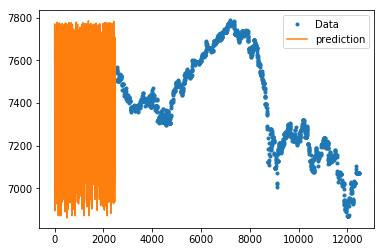

In [27]:
fig, ax = plt.subplots()
ax.plot(test_target, '.', label="Data")
ax.plot(predictions, '-', label="prediction")
ax.legend(loc="best");
plt.show()

In [28]:
print(test_target.shape)
print(predictions.shape)

(2464,)
(2464,)


## OLS Regression¶

In [29]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form

linear_formula = "Open ~ High + Low + Close + CCI"

# Fit the model to our data using the formula.
ftse_model = smf.ols(formula=linear_formula, data=df2).fit()

In [30]:
#5 fold cross validation for r-squared
sk_ftse_model = linear_model.LinearRegression()
score = cross_val_score(sk_ftse_model, test_data, test_target, cv=5)
print("R-squared Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))

R-squared Accuracy: 0.9997 (+/- 0.0001)



Parameters

 Intercept   -1.589643
High         0.822022
Low          0.747771
Close       -0.569597
CCI         -0.005269
dtype: float64

P-values

 Intercept    2.648419e-02
High         0.000000e+00
Low          0.000000e+00
Close        0.000000e+00
CCI          1.073122e-99
dtype: float64

Confidence Intervals


,0,1
Intercept,-2.993664,-0.185622
High,0.811699,0.832345
Low,0.737775,0.757766
Close,-0.585133,-0.554061
CCI,-0.005751,-0.004786


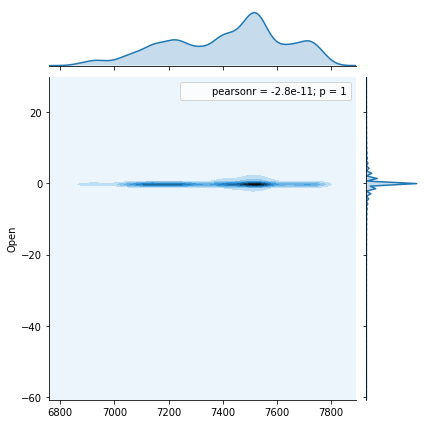

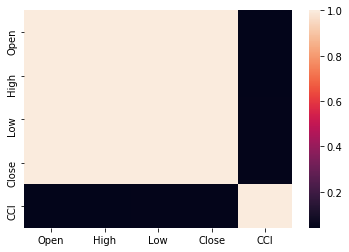

In [31]:
#Check parameters
print ("\nParameters\n\n", ftse_model.params)

#Verify low p-values and confidence intervals to keep features
print ("\nP-values\n\n", ftse_model.pvalues)
print ("\nConfidence Intervals")
display(ftse_model.conf_int())

#Residuals
ols_ypred = ftse_model.predict()
ols_residual = ols_ypred - Y

sns.jointplot(ols_ypred, ols_residual, kind = 'kde')
plt.show()

sns.heatmap(df2.corr())
plt.show()

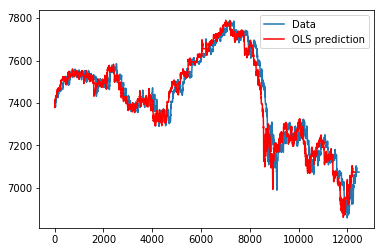

In [32]:
fig, ax = plt.subplots()
ax.plot(Y, '-', label="Data")
ax.plot(np.hstack((ols_ypred)), 'r', label="OLS prediction")
ax.legend(loc="best");
plt.show()

In [33]:
print(Y.shape)
print(ols_ypred.shape)

(12318,)
(12318,)


## KNN Regression¶

Nearest neighbors: 5
R-squared Accuracy: 0.9364 (+/- 0.1725)
Nearest neighbors: 15
R-squared Accuracy: 0.9089 (+/- 0.2595)
Nearest neighbors: 25
R-squared Accuracy: 0.8960 (+/- 0.2958)
Nearest neighbors: 35
R-squared Accuracy: 0.8867 (+/- 0.3162)
Nearest neighbors: 45
R-squared Accuracy: 0.8774 (+/- 0.3345)
Nearest neighbors: 55
R-squared Accuracy: 0.8677 (+/- 0.3563)
Nearest neighbors: 65
R-squared Accuracy: 0.8588 (+/- 0.3756)


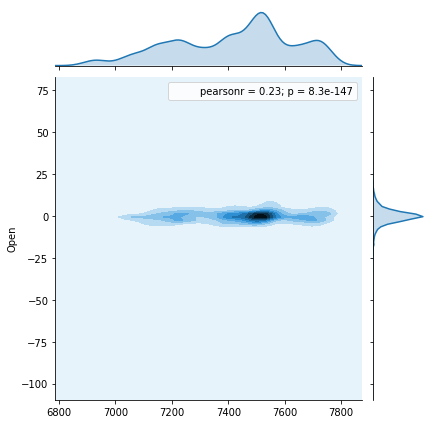

In [34]:
# Our input data frame will be the z-scores this time instead of raw data.
X_norm = X.apply(stats.zscore)
for k in range(5,75,10):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform')
    knn.fit(X_norm,Y)
    knn_ypred = knn.predict(X_norm)
    score = cross_val_score(knn, X_norm, Y, cv=5)
    print ("Nearest neighbors: {}".format(k))
    print("R-squared Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))
knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform')
knn.fit(X_norm,Y)
knn_ypred = knn.predict(X_norm)
knn_residual = Y - knn_ypred
sns.jointplot(knn_ypred, knn_residual, kind = "kde")
plt.show()

### Testing with the splitted dataset

In [35]:
from sklearn import utils
from sklearn.metrics import accuracy_score

In [36]:
train_data2 = train_data.astype('int')
test_data2 = test_data.astype('int')
train_target2 = train_target.astype('int')
test_target2 = test_target.astype('int')

In [37]:
print(train_data2.shape)
print(train_target2.shape)
print(test_data2.shape)
print(test_target2.shape)
print(Y.shape)

(9854, 2)
(9854,)
(2464, 2)
(2464,)
(12318,)


In [38]:
knn = neighbors.KNeighborsRegressor(n_neighbors=1)
knn.fit(train_data2, train_target2)
y_pred = knn.predict(test_data2)
score = cross_val_score(knn, test_data2, test_target2, cv=5)
print("R-squared Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))

R-squared Accuracy: 0.8742 (+/- 0.0885)


In [39]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 51)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_data2, train_target2)
    y_pred = knn.predict(test_data2)
    scores = cross_val_score(knn, test_data2, test_target2, cv=50)
print(scores)

[ 0.94694522  0.95691187  0.89665587  0.94946132  0.93277493  0.91794647
  0.93027382  0.94106015  0.93070429  0.93245858  0.95561336  0.88673317
  0.90829998  0.9429108   0.93557491  0.95262461  0.94498688  0.92722073
  0.94334894  0.93815891  0.94711448  0.9426775   0.93509376  0.94389657
  0.93758979  0.91191677  0.91945194  0.92327274  0.95066659  0.90478202
  0.94604764  0.91255442  0.9607126   0.91299331  0.91731946  0.9375779
  0.94661697  0.95174712  0.93363342  0.91415689  0.93225638  0.93983873
  0.92513118  0.95650444  0.90787092  0.911621    0.92481008  0.9274435
  0.92652947  0.92960342]


In [40]:
k_range

range(1, 51)

In [41]:
scores

array([ 0.94694522,  0.95691187,  0.89665587,  0.94946132,  0.93277493,
        0.91794647,  0.93027382,  0.94106015,  0.93070429,  0.93245858,
        0.95561336,  0.88673317,  0.90829998,  0.9429108 ,  0.93557491,
        0.95262461,  0.94498688,  0.92722073,  0.94334894,  0.93815891,
        0.94711448,  0.9426775 ,  0.93509376,  0.94389657,  0.93758979,
        0.91191677,  0.91945194,  0.92327274,  0.95066659,  0.90478202,
        0.94604764,  0.91255442,  0.9607126 ,  0.91299331,  0.91731946,
        0.9375779 ,  0.94661697,  0.95174712,  0.93363342,  0.91415689,
        0.93225638,  0.93983873,  0.92513118,  0.95650444,  0.90787092,
        0.911621  ,  0.92481008,  0.9274435 ,  0.92652947,  0.92960342])

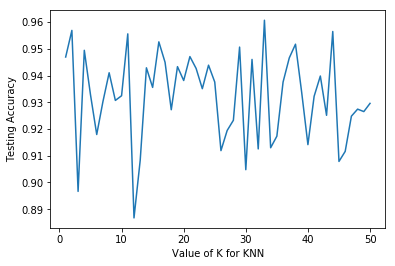

In [42]:
# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

In [43]:
#Approximately best K
knn = neighbors.KNeighborsRegressor(n_neighbors=32)
knn.fit(train_data2, train_target2)
y_pred = knn.predict(test_data2)
#score = cross_val_score(knn, test_data2, test_target2, cv=5)
#print("R-squared Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))

In [44]:
knn.score(test_data2, test_target2)

0.93696133560818817

In [45]:
from sklearn.metrics import r2_score
r2_score(test_target2, y_pred)

0.93696133560818817

In [46]:
print(train_data2.shape)
print(train_target2.shape)
print(test_data2.shape)
print(test_target2.shape)
print(Y.shape)

(9854, 2)
(9854,)
(2464, 2)
(2464,)
(12318,)


In [47]:
from sklearn.grid_search import GridSearchCV

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [48]:
#Best K
params = {"n_neighbors": np.arange(1,50), "metric": ["euclidean", "cityblock"]}
grid = GridSearchCV(estimator=knn,param_grid=params)
grid.fit(train_data2, train_target2)
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)

0.937094052401281
48


In [49]:
#Approximately best K
knn_best = neighbors.KNeighborsRegressor(n_neighbors=48)
knn_best.fit(train_data2, train_target2)
y_pred_best = knn_best.predict(test_data2)

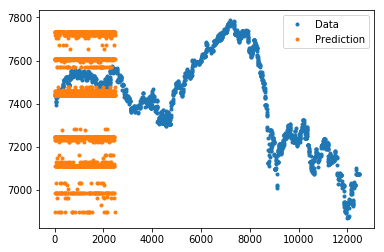

In [50]:
fig, ax = plt.subplots()
ax.plot(test_target2, '.', label="Data")
ax.plot(y_pred_best, '.', label="Prediction")
ax.legend(loc="best");
plt.show()

In [51]:
print(test_target2.shape)
print(y_pred.shape)

(2464,)
(2464,)


In [52]:
y_pred_best_list = y_pred_best.tolist()

In [53]:
y_pred_best_int = y_pred_best.astype('int')

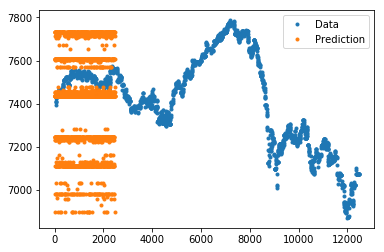

In [54]:
fig, ax = plt.subplots()
ax.plot(test_target2, '.', label="Data")
ax.plot(y_pred_best_int, '.', label="Prediction")
ax.legend(loc="best");
plt.show()

In [55]:
y_pred_best_int.shape

(2464,)

In [56]:
test_target2.shape

(2464,)

In [57]:
y_pred_series = pd.Series(y_pred_best)

In [58]:
test_target2_series = pd.Series(test_target2)

In [59]:
dfknn = pd.concat([test_target2_series,y_pred_series], axis=1)

In [60]:
#Best K
params = {"n_neighbors": np.arange(1,50), "metric": ["euclidean", "cityblock"]}
grid = GridSearchCV(estimator=knn,param_grid=params)
grid.fit(train_data2, train_target2)
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)

0.937094052401281
48


In [61]:
dfknn2 = dfknn.dropna()

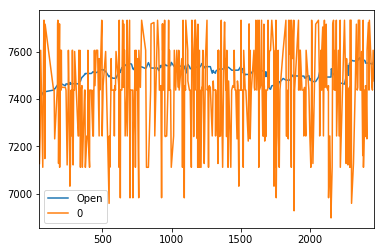

In [62]:
dfknn2.plot()
plt.show()